In [1]:
# Importing initial packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# PyTorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset, random_split

In [2]:
# Setting Hyperparameters

n_factors = 100
dropout_rate = 0.2
batch_size = 256
epochs = 5
lr = 0.005
accumulation_steps = 4
weight_decay = 1e-5
step_size = 10
gamma = 0.1
patience = 5

In [3]:
# Setting the device to GPU for parallelization
device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## Data Loading, Cleaning, and Preprocessing

### Data Loading

In [4]:
# In my project folder I added a data folder with both files (found in repo README) but did not push (gitignore) due to size
movies = pd.read_csv('ml-25m/movies.csv')
ratings = pd.read_csv('ml-25m/ratings_filled.csv')

### Data Preprocessing

In [5]:
# Extract unique IDs and create mappings
user_id_mapping = {user_id: idx for idx, user_id in enumerate(ratings['userId'].unique())}
movie_id_mapping = {movie_id: idx for idx, movie_id in enumerate(ratings['movieId'].unique())}

# Initialize the user-rating matrix
num_users = len(user_id_mapping)
num_movies = len(movie_id_mapping)
user_rating_matrix = np.zeros((num_users, num_movies), dtype=np.float32)

# Map the IDs to indices and fill the matrix
ratings['user_idx'] = ratings['userId'].map(user_id_mapping)
ratings['movie_idx'] = ratings['movieId'].map(movie_id_mapping)
user_rating_matrix[ratings['user_idx'], ratings['movie_idx']] = ratings['rating']

# Output the matrix shape
print(f"Shape of the numpy matrix: {user_rating_matrix.shape}; representing {user_rating_matrix.shape[0]} users with {user_rating_matrix.shape[1]} movies.")



Shape of the numpy matrix: (28468, 35577); representing 28468 users with 35577 movies.


In [6]:
user_rating_matrix_tensor = torch.tensor(user_rating_matrix, dtype=torch.float32)

# Define the split ratio
test_size = 0.2
num_samples = user_rating_matrix_tensor.shape[0]
split_index = int(num_samples * (1 - test_size))

# Shuffle the data
indices = torch.randperm(num_samples)

# Split the dataset
train_indices = indices[:split_index]
test_indices = indices[split_index:]

train_data = user_rating_matrix_tensor[train_indices]
test_data = user_rating_matrix_tensor[test_indices]

# Convert to PyTorch tensors
train_data = torch.FloatTensor(train_data)
test_data = torch.FloatTensor(test_data)

print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

Train data shape: torch.Size([22774, 35577])
Test data shape: torch.Size([5694, 35577])


### Creating DataLoader

In [7]:
class RatingsDataset(Dataset):
    def __init__(self, data):
        self.data = data.nonzero(as_tuple=True) # Get the indices of non-zero elements
        self.ratings = data[self.data]          # Using non-zero indiced to extract those ratings

    def __len__ (self):
        return len(self.data[0])

    def __getitem__ (self, idx):
        user = self.data[0][idx]
        item = self.data[1][idx]
        rating = self.ratings[idx]

        return user, item, rating

# Create training and testing datasets
train_dataset = RatingsDataset(train_data)
test_dataset = RatingsDataset(test_data)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# Print dataset information
print(f"Number of samples in train_dataset: {len(train_dataset)}")
print(f"Number of samples in test_dataset: {len(test_dataset)}")

Number of samples in train_dataset: 3440894
Number of samples in test_dataset: 883596


## Model Development

### Defining Recommender model


In [8]:
class MFRecommender(nn.Module):
    def __init__(self, num_users, num_items, n_factors, dropout_rate):
        super(MFRecommender, self).__init__()
        
        # Embedding layers
        self.user_embedding = nn.Embedding(num_users, n_factors)
        self.item_embedding = nn.Embedding(num_items, n_factors)
        
        # Fully connected layers
        self.fc1 = nn.Linear(n_factors, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(dropout_rate)  # Dropout to prevent overfitting

        # Embedding Initialization
        nn.init.normal_(self.user_embedding.weight, std=0.01)
        nn.init.normal_(self.item_embedding.weight, std=0.01)

    def forward(self, user, item):
        # Get embeddings
        user_emb = self.user_embedding(user)
        item_emb = self.item_embedding(item)
        
        # Element-wise multiplication of user and item embeddings        
        x = user_emb * item_emb
        
        # Pass through fully connected layers with ReLU activation and dropout
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)   
        x = torch.relu(self.fc2(x))
        x = self.dropout(x) 
        
        return self.fc3(x)


### Initializing the Model


In [9]:
num_users, num_items = user_rating_matrix.shape


model = MFRecommender(num_users, num_items, n_factors, dropout_rate).to(device)

# Adjust the model initialization
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)  # Add weight decay for regularization
scheduler = StepLR(optimizer, step_size, gamma)
criterion = nn.MSELoss().to(device)

# Use mixed precision training (if supported)
scaler = torch.cuda.amp.GradScaler()


### Defining traing loop function 

In [10]:
def train_model(model, train_loader, optimizer, criterion, scaler, scheduler, epochs, patience=None):
    model.train()
    best_loss = float('inf')
    patience_counter = 0
    train_losses = {'train_loss': []}

    for epoch in range(epochs):
        epoch_loss = 0
        # Initialize tqdm progress bar
        with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}", unit="batch") as pbar:
            for user_batch, item_batch, rating_batch in train_loader:
                user_batch = user_batch.to(device)
                item_batch = item_batch.to(device)
                rating_batch = rating_batch.to(device)
                
                optimizer.zero_grad()
                
                with torch.cuda.amp.autocast():
                    output = model(user_batch, item_batch).squeeze()
                    loss = criterion(output, rating_batch)
                
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                
                epoch_loss += loss.item()
                pbar.set_postfix({"loss": loss.item()})
                pbar.update(1)
        
        scheduler.step()
        avg_loss = epoch_loss / len(train_loader)
        train_losses['train_loss'].append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss}")

        # Check for early stopping
        if patience is not None:
            if avg_loss < best_loss:
                best_loss = avg_loss
                patience_counter = 0
                # Save the best model
                torch.save(model.state_dict(), 'best_model_state_dict.pth')
                print("Best model saved")
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print("Early stopping triggered")
                    break
    
    return train_losses


In [11]:

# Run Training Loop  
train_losses = train_model(model, train_loader, optimizer, criterion, scaler, scheduler, epochs, patience=patience)

Epoch 4/5: 100%|██████████| 13441/13441 [01:25<00:00, 156.93batch/s, loss=0.743]


Epoch 4/5, Loss: 0.7312363415377789
Best model saved


Epoch 5/5: 100%|██████████| 13441/13441 [01:35<00:00, 140.32batch/s, loss=0.698]

Epoch 5/5, Loss: 0.7300655736551426
Best model saved


### Model Evaluation

In [12]:
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    all_predictions = []
    all_actuals = []

    with torch.no_grad():
        for user_batch, item_batch, rating_batch in test_loader:
            user_batch, item_batch, rating_batch = user_batch.to(device), item_batch.to(device), rating_batch.to(device)
            output = model(user_batch, item_batch).squeeze()
            loss = criterion(output, rating_batch)
            test_loss += loss.item()
            all_predictions.extend(output.cpu().numpy())
            all_actuals.extend(rating_batch.cpu().numpy())

    avg_test_loss = test_loss / len(test_loader)
    print(f"Test Loss: {avg_test_loss}")
    return avg_test_loss, all_predictions, all_actuals

# Evaluate the model before saving
avg_test_loss, predictions, actuals = evaluate_model(model, test_loader, criterion)

Test Loss: 1.1315982566578777


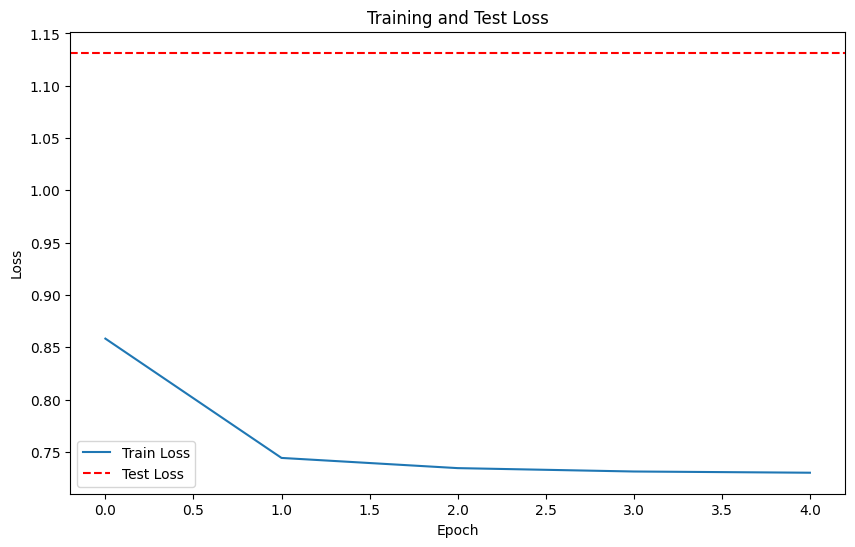

In [13]:
# Plot the test loss

plt.figure(figsize=(10, 6))
plt.plot(range(len(train_losses['train_loss'])), train_losses['train_loss'], label='Train Loss')
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

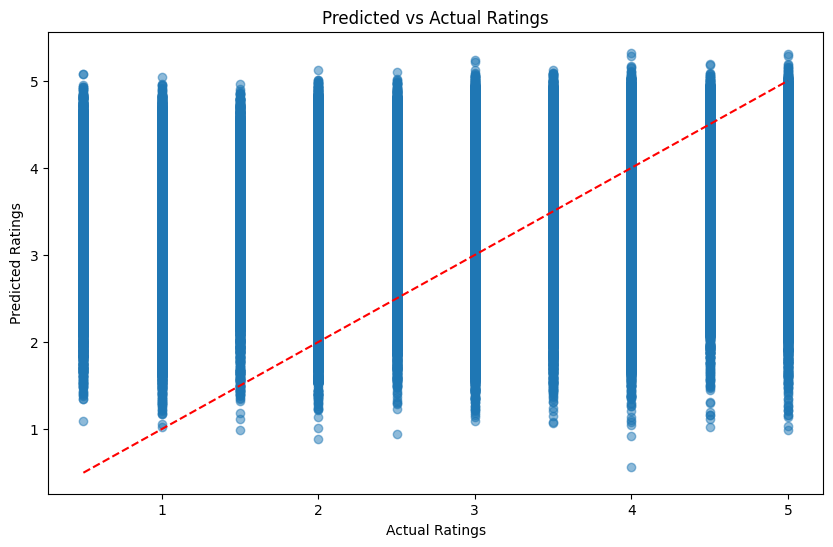

In [14]:
# Visualize Predictions vs Actual Ratings
plt.figure(figsize=(10, 6))
plt.scatter(actuals, predictions, alpha=0.5)
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'r--')  # Line for reference
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Predicted vs Actual Ratings')
plt.show()

In [17]:
# Convert Model Parameters to Half-Precision
model.half()
for layer in model.modules():
    if isinstance(layer, nn.BatchNorm1d):
        layer.float()

# Save the final model
torch.save(model.state_dict(), 'final_model_state_dict.pth')

In [24]:
# Define dummy input based on your model's expected input and move to the same device
dummy_user = torch.tensor([0], dtype=torch.int64).to(device)
dummy_item = torch.tensor([0], dtype=torch.int64).to(device)

# Path where the ONNX model will be saved
onnx_model_path = 'model.onnx'

# Export the model
torch.onnx.export(
    model,                           # The model to be exported
    (dummy_user, dummy_item),        # Dummy input to trace the model
    onnx_model_path,                 # Path to save the ONNX model
    input_names=['user', 'item'],    # Input names for the model
    output_names=['rating'],         # Output name for the model
    opset_version=11                 # ONNX version to export (adjust if necessary)
)

print(f"Model has been successfully exported to {onnx_model_path}")


Model has been successfully exported to model.onnx


## Using the Model 

#### recommend movies for a given user ID:

In [54]:

# Function to validate movie IDs
def validate_movie_ids(movie_ids, movie_id_mapping):
    valid_movie_ids = [movie_id for movie_id in movie_ids if movie_id in movie_id_mapping]
    if len(valid_movie_ids) != len(movie_ids):
        print("Some movie IDs are out of range and have been excluded from the recommendations.")
    return valid_movie_ids

# Function to recommend movies
def recommend_movies(user_id, top_n=10):
    model.eval()  # Set model to evaluation mode
    
    user_idx = user_id_mapping.get(user_id, None)
    if user_idx is None:
        print(f"User ID {user_id} is out of range and will be skipped.")
        return []

    all_movie_indices = list(movie_id_mapping.values())
    user = torch.tensor([user_idx] * len(all_movie_indices), device=device)
    movies = torch.tensor(all_movie_indices, device=device)

    with torch.no_grad():
        predicted_ratings = model(user, movies).squeeze()
        if predicted_ratings.dim() == 0:  # Handle the case where the result is a single value
            predicted_ratings = predicted_ratings.unsqueeze(0)

    top_movie_indices = predicted_ratings.argsort(descending=True)[:top_n]
    recommended_movie_ids = [list(movie_id_mapping.keys())[i] for i in top_movie_indices]
    recommended_ratings = predicted_ratings[top_movie_indices].tolist()
    
    return list(zip(recommended_movie_ids, recommended_ratings))

# Example usage for recommendations
user_id_example = 28468  # Replace with the user ID you want to get recommendations for
top_n_example = 10  # Number of top recommendations to fetch
recommended_movies = recommend_movies(user_id_example, top_n=top_n_example)

# Ensure 'movies' DataFrame has a column 'title'
if recommended_movies:
    for movie_id, rating in recommended_movies:
        movie_title = movies.loc[movies['movieId'] == movie_id, 'title'].values[0]
        print(f"Movie: {movie_title}, Estimated Rating: {rating:.2f}")
else:
    print("No recommendations available for the given user.")


User ID 28469 is out of range and will be skipped.
No recommendations available for the given user.


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_CUDA__index_select)